In [35]:
import pymc as pm
import csv
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Link to the data set
# https://www.kaggle.com/datasets/patricklford/water-and-air-quality

file = open('Cities1.csv')
csvreader = csv.reader(file)
header = []
header = next(csvreader)
normal_x = []
non_normal_x = []
for row in csvreader:
    normal_x.append(float(row[header.index("WaterPollution")]))
    non_normal_x.append(float(row[header.index("AirQuality")]))

In [36]:
# Data with normal likelihood

normal_gamma_model = pm.Model()
with normal_gamma_model: 
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs1 = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=normal_x)
    
    idata_HMC1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


HMC Split-Rhats {'theta': 1.0004, 'phi': 1.0003} | 

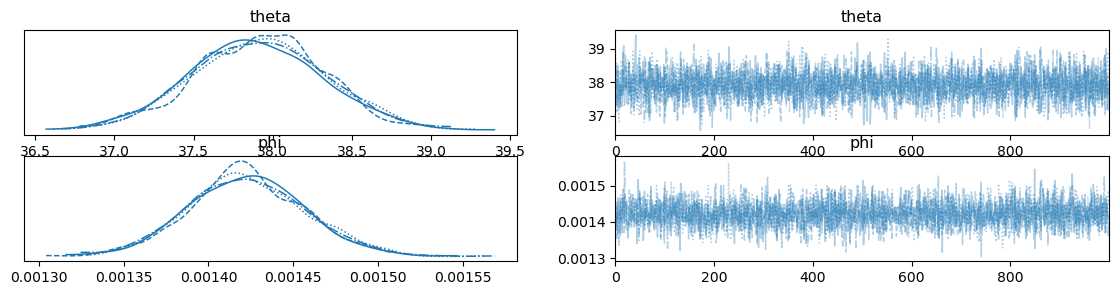

In [37]:
fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC1, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC1).items()}, end=' | ')

/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning:

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

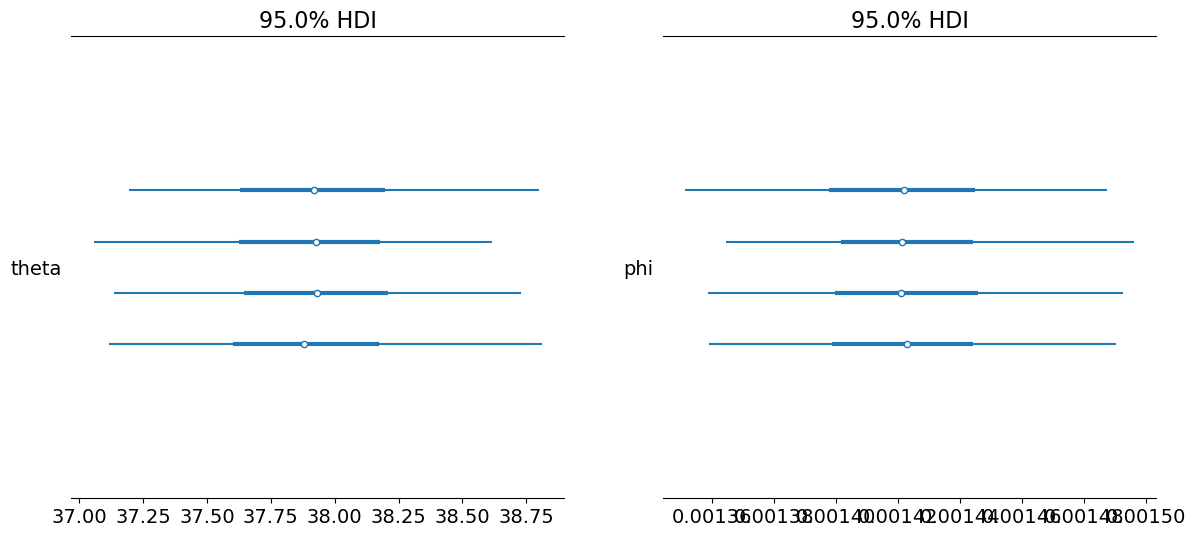

In [38]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC1, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_HMC1, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1])

In [39]:
# Data with non-normal likelihood

non_normal_gamma_model = pm.Model()
with non_normal_gamma_model: 
    alpha = pm.Normal("alpha", mu=2, sigma=1)
    # Since beta should be positive, I used Wald distribution with range of (0, inf)
    beta = pm.Wald("beta", mu=5, lam=5)
    # Since the data seems left-skewed, use Wald distirbution with left-skewness
    x_obs2 = pm.Cauchy("likelihood", alpha=alpha, beta=beta, observed=non_normal_x)
    
    idata_HMC2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


HMC Split-Rhats {'alpha': 0.9999, 'beta': 1.0032} | 

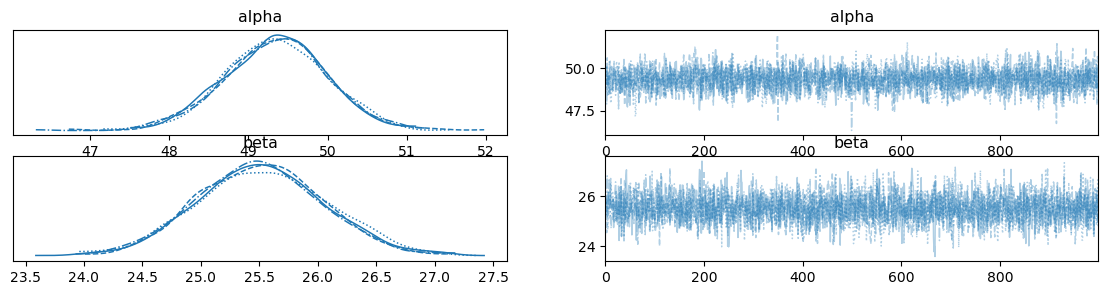

In [40]:
fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC2, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC2).items()}, end=' | ')

/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning:

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

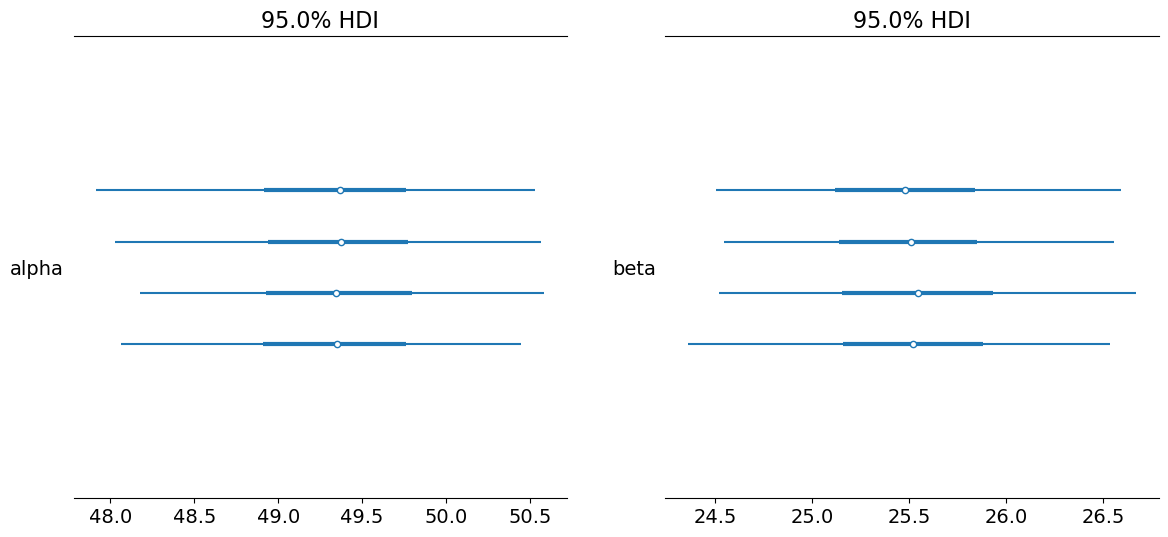

In [41]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC2, var_names=["alpha"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_HMC2, var_names=["beta"], combined=False, hdi_prob=0.95, ax=ax[1])

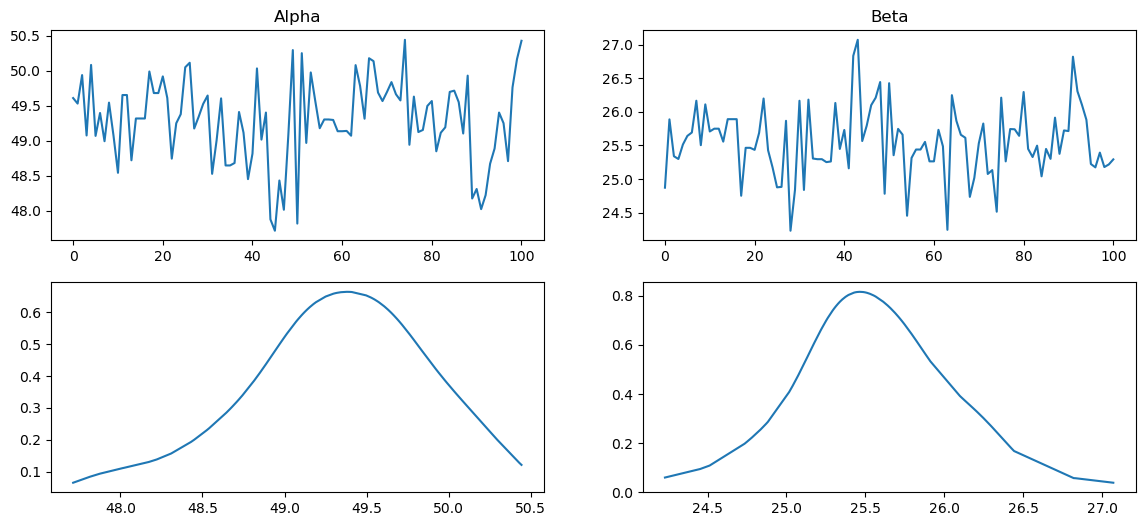

In [42]:
# Analysis of the MCMC chains

fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100

mcmc_chain = idata_HMC2.posterior["alpha"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("Alpha")

mcmc_chain = idata_HMC2.posterior["beta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("Beta");

Autocorrelation for alpha (MCMC) chain 0.11372558385283221
Autocorrelation for beta (MCMC) chain 0.11302383390259366


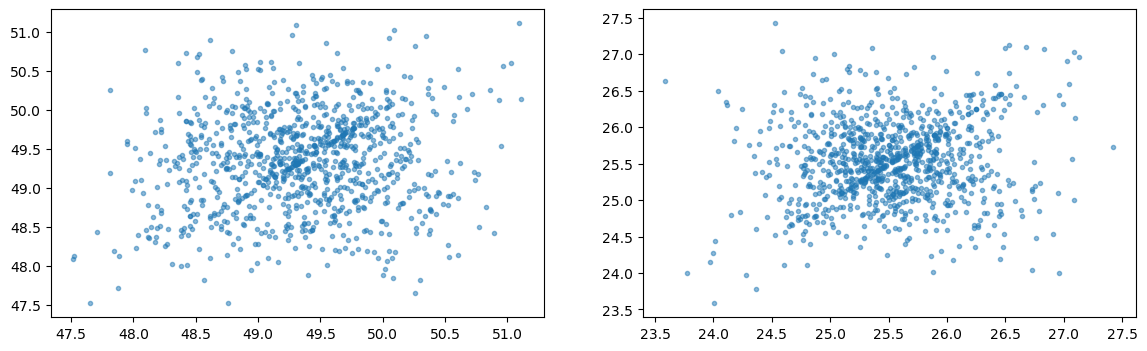

In [43]:
fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC2.posterior["alpha"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC2.posterior["alpha"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for alpha (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_HMC2.posterior["beta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC2.posterior["beta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for beta (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

Autocorrelations for both alpha and beta are relatively low. This suggests than the results obtained by MCMC sampling are useful for estimating posterior mean and credible interval of non-normal likelihood model's parameters.

In [44]:
print("Number of MCMC samples (alpha):", idata_HMC2.posterior['alpha'].values.flatten().shape[-1])
print("Number of MCMC samples (beta):", idata_HMC2.posterior['beta'].values.flatten().shape[-1])
az.summary(idata_HMC2, round_to=2)

Number of MCMC samples (alpha): 4000
Number of MCMC samples (beta): 4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,49.35,0.64,48.17,50.56,0.01,0.01,2940.62,2477.73,1.0
beta,25.52,0.55,24.52,26.54,0.01,0.01,2790.68,2407.24,1.0


'ess_bulk' for both alpha and beta are relatively large compared to the total number of samples 4000. Similarly, 'ess_tail' for both parameters are also relatively large compared to the total 4000. This suggests than the results obtained by MCMC sampling are useful for estimating posterior mean and credible interval of non-normal likelihood model's parameters.